In [99]:
from dataset import MolerDataset, MolerData
from utils import pprint_pyg_obj
from torch_geometric.loader import DataLoader

dataset = MolerDataset(
    root = '/data/ongh0068', 
    raw_moler_trace_dataset_parent_folder = '/data/ongh0068/l1000/trace_playground',
    output_pyg_trace_dataset_parent_folder = '/data/ongh0068/l1000/pyg_output_playground',
    split = 'train',
)

loader = DataLoader(dataset, batch_size=16, shuffle=False, follow_batch = [
    'correct_edge_choices',
    'correct_edge_types',
    'valid_edge_choices',
    'valid_attachment_point_choices',
    'correct_attachment_point_choice',
    'correct_node_type_choices',
    'original_graph_x',
    'correct_first_node_type_choices'
])

Processing...
Done!


In [129]:
for batch in loader:
    
    break

In [117]:
import torch
params = {'full_graph_encoder': {'input_feature_dim': 32,
  'atom_or_motif_vocab_size': 139},
 'partial_graph_encoder': {'input_feature_dim': 32},
 'mean_log_var_mlp': {'input_feature_dim': 832, 'output_size': 1024},
 'decoder': {'node_type_selector': {'input_feature_dim': 1344,
   'output_size': 140},
  'node_type_loss_weights': torch.tensor([10.0000,  0.1000,  0.1000,  0.1000,  0.7879,  0.4924,  0.6060, 10.0000,
           7.8786, 10.0000,  7.8786,  0.1000,  0.6565,  0.6565,  0.9848,  0.8754,
           0.8754,  1.1255,  0.9848,  1.3131,  1.5757,  1.9696,  1.5757,  1.9696,
           2.6262,  1.9696,  1.9696,  7.8786,  7.8786,  3.9393,  2.6262,  2.6262,
           2.6262,  2.6262,  3.9393,  7.8786,  7.8786,  7.8786,  3.9393,  7.8786,
          10.0000,  7.8786,  3.9393,  3.9393,  3.9393,  3.9393,  3.9393,  3.9393,
           3.9393,  3.9393,  3.9393,  3.9393,  3.9393,  3.9393,  7.8786,  7.8786,
          10.0000, 10.0000,  7.8786,  7.8786, 10.0000,  7.8786,  7.8786, 10.0000,
           7.8786,  7.8786, 10.0000,  7.8786, 10.0000,  7.8786,  7.8786, 10.0000,
           7.8786,  7.8786,  7.8786, 10.0000, 10.0000,  7.8786,  7.8786,  7.8786,
           7.8786,  7.8786, 10.0000, 10.0000, 10.0000, 10.0000,  7.8786, 10.0000,
          10.0000, 10.0000,  7.8786, 10.0000,  7.8786, 10.0000,  7.8786, 10.0000,
          10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,  7.8786,
          10.0000,  7.8786,  7.8786,  7.8786,  7.8786, 10.0000,  7.8786, 10.0000,
          10.0000, 10.0000,  7.8786,  7.8786,  7.8786,  7.8786,  7.8786,  7.8786,
           7.8786,  7.8786,  7.8786,  7.8786,  7.8786,  7.8786,  7.8786,  7.8786,
           7.8786,  7.8786,  7.8786,  7.8786,  7.8786,  7.8786,  7.8786,  7.8786,
           7.8786,  7.8786,  7.8786,  0.1000]),
  'no_more_edges_repr': (1, 835),
  'edge_candidate_scorer': {'input_feature_dim': 3011, 'output_size': 1},
  'edge_type_selector': {'input_feature_dim': 3011, 'output_size': 3},
  'attachment_point_selector': {'input_feature_dim': 2176, 'output_size': 1},
  'first_node_type_selector': {'input_feature_dim': 512, 'output_size': 139}},
 'latent_sample_strategy': 'per_graph',
 'latent_repr_dim': 512,
 'latent_repr_size': 512}

In [118]:
%load_ext autoreload
%autoreload 2
from model import BaseModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
model = BaseModel(params, dataset).eval()

moler_output = model._run_step(batch)

loss = model.compute_loss(moler_output, batch)

loss

tensor(3.2114, dtype=torch.float64, grad_fn=<AddBackward0>)

In [6]:
def decode(
    graph_representations,
    initial_molecules= None,
    mol_ids = None,
    store_generation_traces = False,
    max_num_steps=120,
    beam_size= 1,
    sampling_mode = 'greedy',
)

SyntaxError: invalid syntax (2536383891.py, line 9)

In [6]:
with torch.no_grad():
    input_molecule_representations = model._full_graph_encoder(
        original_graph_node_categorical_features=batch.original_graph_node_categorical_features,
        node_features=batch.original_graph_x.float(),
        edge_index=batch.original_graph_edge_index,
        edge_type=batch.original_graph_edge_type.int(),
        batch_index=batch.original_graph_x_batch,
    )


    partial_graph_representions, node_representations = model._partial_graph_encoder(
        node_features=batch.x,
        edge_index=batch.edge_index.long(),
        edge_type=batch.edge_type.int(),
        batch_index=batch.batch,
    )
    # Apply latent sampling strategy
    p, q, latent_representations = model.sample_from_latent_repr(
        input_molecule_representations
    )

In [7]:
latent_representations.shape

torch.Size([16, 512])

# Preprocessing before algorithm

In [7]:
from rdkit import Chem
from molecule_generation.chem.molecule_dataset_utils import BOND_DICT
from molecule_generation.chem.motif_utils import (
    find_motifs_from_vocabulary,
)
uses_motifs = True
initial_molecules = None
mol_ids = None
store_generation_traces = False

graph_representations = latent_representations

if initial_molecules is None:
    initial_molecules = [None] * len(graph_representations)

# Replace `None` in initial_molecules with empty molecules.
initial_molecules = [
    Chem.Mol() if initMol is None else initMol for initMol in initial_molecules
]
if mol_ids is None:
    mol_ids = range(len(graph_representations))

In [8]:
from molecule_generation.utils.moler_decoding_utils import (
    DecoderSamplingMode,
    sample_indices_from_logprobs,
    restrict_to_beam_size_per_mol,
    MoLeRDecoderState,
    MoleculeGenerationAtomChoiceInfo,
    MoleculeGenerationAttachmentPointChoiceInfo,
    MoleculeGenerationEdgeChoiceInfo,
    MoleculeGenerationEdgeCandidateInfo,
)

In [9]:
decoder_states = []


# preprocessing for when a scaffold is given
for graph_repr, init_mol, mol_id in zip(graph_representations, initial_molecules, mol_ids):
    num_free_bond_slots = [0] * len(init_mol.GetAtoms())

    atom_ids_to_remove = []
    atom_ids_to_keep = []

    for atom in init_mol.GetAtoms():
        if atom.GetAtomicNum() == 0:
            # Atomic number 0 means a placeholder atom that signifies an attachment point.
            bonds = atom.GetBonds()

            if len(bonds) > 1:
                scaffold = Chem.MolToSmiles(init_mol)
                raise ValueError(
                    f"Scaffold {scaffold} contains a [*] atom with at least two bonds."
                )

            if not bonds:
                # This is a very odd case: either the scaffold we got is disconnected, or
                # it consists of just a single * atom.
                scaffold = Chem.MolToSmiles(init_mol)
                raise ValueError(f"Scaffold {scaffold} contains a [*] atom with no bonds.")

            [bond] = bonds
            begin_idx = bond.GetBeginAtomIdx()
            end_idx = bond.GetEndAtomIdx()

            neighbour_idx = begin_idx if begin_idx != atom.GetIdx() else end_idx
            num_free_bond_slots[neighbour_idx] += 1

            atom_ids_to_remove.append(atom.GetIdx())
        else:
            atom_ids_to_keep.append(atom.GetIdx())

    if not atom_ids_to_remove:
        # No explicit attachment points, so assume we can connect anywhere.
        num_free_bond_slots = None
    else:
        num_free_bond_slots = [num_free_bond_slots[idx] for idx in atom_ids_to_keep]
        init_mol = Chem.RWMol(init_mol)

        # Remove atoms starting from largest index, so that we don't have to account for
        # indices shifting during removal.
        for atom_idx in reversed(atom_ids_to_remove):
            init_mol.RemoveAtom(atom_idx)

        # Determine how the scaffold atoms will get reordered when we canonicalize it, so we can
        # permute `num_free_bond_slots` appropriately.
        canonical_ordering = compute_canonical_atom_order(init_mol)
        num_free_bond_slots = [num_free_bond_slots[idx] for idx in canonical_ordering]

    # Now canonicalize, which renumbers all the atoms, but we've applied the same
    # renumbering to `num_free_bond_slots` earlier.
    init_mol = Chem.MolFromSmiles(Chem.MolToSmiles(init_mol))

    # Clear aromatic flags in the scaffold, since partial graphs during training never have
    # them set (however we _do_ run `AtomIsAromaticFeatureExtractor`, it just always returns
    # 0 for partial graphs during training).
    # TODO(kmaziarz): Consider fixing this.
    Chem.Kekulize(init_mol, clearAromaticFlags=True)

    init_atom_types = []
    # TODO(kmaziarz): We need to be more careful in how the initial molecule looks like, to
    # make sure that `init_mol`s have correct atom features (e.g. charges).
    for atom in init_mol.GetAtoms():
        init_atom_types.append(get_atom_symbol(atom))
    adjacency_lists = [[] for _ in range(len(BOND_DICT))]
    for bond in init_mol.GetBonds():
        bond_type_idx = BOND_DICT[str(bond.GetBondType())]
        adjacency_lists[bond_type_idx].append(
            (bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        )
        adjacency_lists[bond_type_idx].append(
            (bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())
        )

    if uses_motifs:
        init_mol_motifs = find_motifs_from_vocabulary(
            molecule=init_mol, motif_vocabulary=dataset._motif_vocabulary
        )
    else:
        init_mol_motifs = []

    decoder_states.append(
        MoLeRDecoderState(
            molecule_representation=graph_repr,
            molecule_id=mol_id,
            molecule=init_mol,
            atom_types=init_atom_types,
            adjacency_lists=adjacency_lists,
            visited_atoms=[atom.GetIdx() for atom in init_mol.GetAtoms()],
            atoms_to_visit=[],
            focus_atom=None,
            # Pseudo-randomly pick last atom from input:
            prior_focus_atom=len(init_atom_types) - 1,
            generation_steps=[] if store_generation_traces else None,
            motifs=init_mol_motifs,
            num_free_bond_slots=num_free_bond_slots,
        )
    )

decoder_states_empty = []
decoder_states_non_empty = []

for decoder_state in decoder_states:
    if decoder_state.molecule.GetNumAtoms() == 0:
        decoder_states_empty.append(decoder_state)
    else:
        decoder_states_non_empty.append(decoder_state)


# _decoder_pick_first_atom_types


In [25]:
# from decoder import MLPDecoder
# from model_utils import get_params

# decoder = MLPDecoder(get_params()['decoder'])

In [37]:
# dataset.node_type_index_to_string

{0: 'UNK',
 1: 'C',
 2: 'O',
 3: 'N',
 4: 'S',
 5: 'Cl',
 6: 'F',
 7: 'N+',
 8: 'O-',
 9: 'B',
 10: 'Br',
 11: 'C1=CC=CC=C1',
 12: 'C1CCNCC1',
 13: 'C1=CC=NC=C1',
 14: 'NC=O',
 15: 'C1CNCCN1',
 16: 'C1CCNC1',
 17: 'O=[N+][O-]',
 18: 'C1CC1',
 19: 'C1COCCN1',
 20: 'O=CO',
 21: 'N=CO',
 22: 'C1=CNN=C1',
 23: 'FC(F)F',
 24: 'CC=O',
 25: 'C1CCOCC1',
 26: 'C1=CC=C2C=CC=CC2=C1',
 27: 'COC=O',
 28: 'CCO',
 29: 'C=CC',
 30: 'C1=CSC=N1',
 31: 'C1=CSC=C1',
 32: 'C1=CON=C1',
 33: 'C1=CC=C2NC=CC2=C1',
 34: 'OC(F)F',
 35: 'O=CNO',
 36: 'CNC=O',
 37: 'CCNC(=O)OC',
 38: 'CCCO',
 39: 'CCC(N)=O',
 40: 'CCC(=O)O',
 41: 'CC(N)=O',
 42: 'CC(C)C',
 43: 'C1CCOC1',
 44: 'C1CCCCC1',
 45: 'C1=NC=C2CCCCC2=N1',
 46: 'C1=COC=C1',
 47: 'C1=CNC=C1',
 48: 'C1=CN=CN=C1',
 49: 'C1=CN=C2C=CC=CC2=C1',
 50: 'C1=CN2N=CC=C2N=C1',
 51: 'C1=CC=C2OC=CCC2=C1',
 52: 'C1=CC=C2N=CC=CC2=C1',
 53: 'C1=CC2=C(CCC2)S1',
 54: 'O=S=O',
 55: 'O=CNCCO',
 56: 'O=CNCCCCCNC=O',
 57: 'O=CNCCC(=O)O',
 58: 'O=CCCO',
 59: 'O=C(O)CS',
 60: 'N[SH]

In [10]:
from decoding_utils import sample_indices_from_logprobs
import numpy as np


num_samples = 1
decoder_states = decoder_states_empty
sampling_mode =  'greedy'
index_to_node_type_map=dataset.node_type_index_to_string

with torch.no_grad():
    # We only need the molecule representations.
    molecule_representations = torch.stack(
        [state.molecule_representation for state in decoder_states]
    )

    first_node_type_logits = model.decoder.pick_first_node_type(
        latent_representations=latent_representations
    )  # Shape [G, NT + 1]

    first_atom_type_logprobs = torch.nn.functional.log_softmax(
        first_node_type_logits[:, 1:], dim=-1 # because index 0 corresponds to UNK
    )  # Shape [G, NT]

    first_atom_type_pick_results = []


    # Iterate over each of the rows independently, sampling for each input state:
    for state_first_atom_type_logprobs in first_atom_type_logprobs:
        picked_atom_type_indices = sample_indices_from_logprobs(
            num_samples, sampling_mode, state_first_atom_type_logprobs
        )

        this_state_results = []

        for picked_atom_type_idx in picked_atom_type_indices:
            pick_logprob = state_first_atom_type_logprobs[picked_atom_type_idx]
            picked_atom_type_idx += 1  # Revert the stripping out of the UNK (index 0) type

            this_state_results.append(
                (index_to_node_type_map[picked_atom_type_idx.item()], pick_logprob)
            )

        first_atom_type_pick_results.append(
            (this_state_results, state_first_atom_type_logprobs)
        )


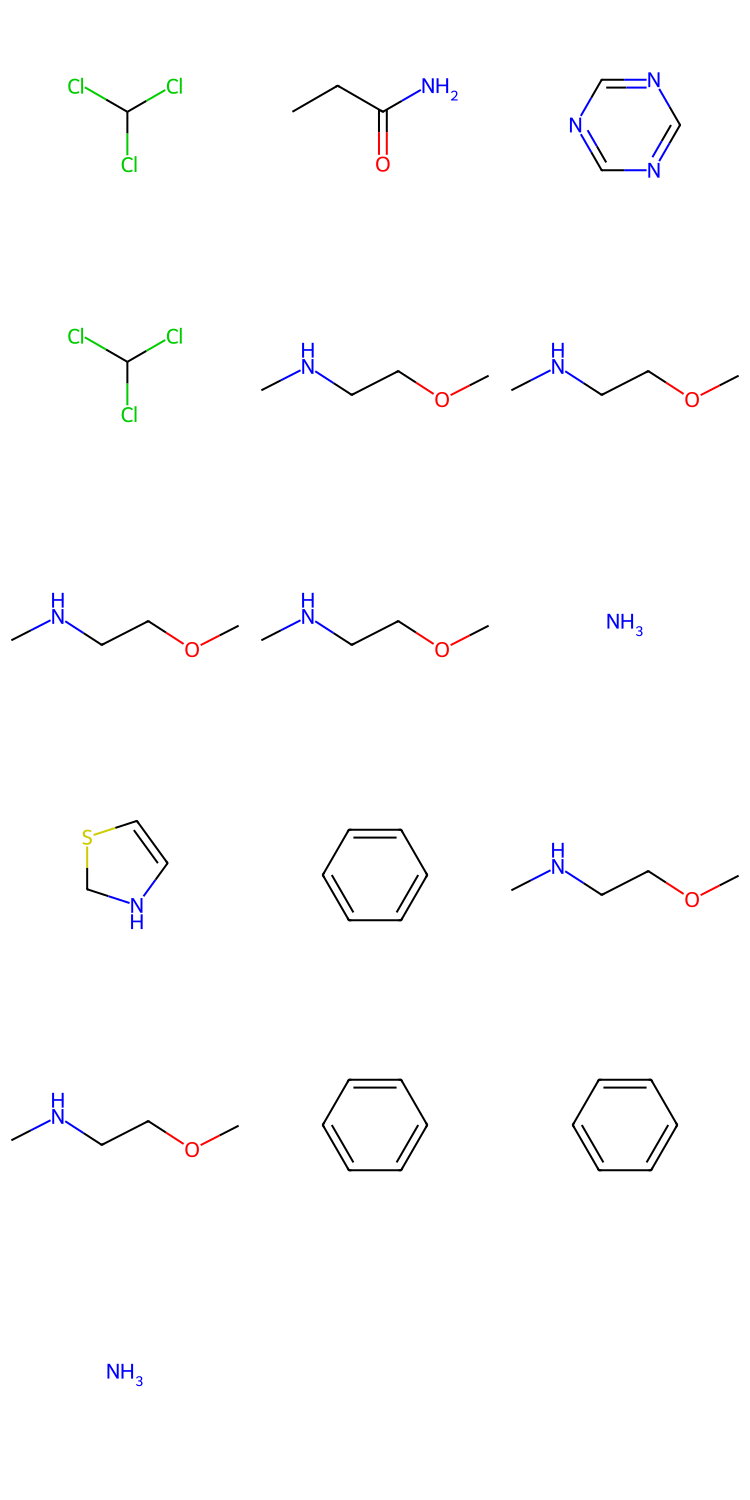

In [58]:
# def view_mol(,)
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(first_atom_type_pick_results[i][0][0][0]) for i in range(len(first_atom_type_pick_results))], subImgSize=(250,250))
# Chem.MolFromSmiles(), Chem.MolFromSmiles(first_atom_type_pick_results[1][0][0][0])

In [20]:
first_atom_type_pick_results[0][0][0]

('ClC(Cl)Cl', tensor(-4.6846))

In [51]:
first_atom_type_pick_results

[([('ClC(Cl)Cl', tensor(-4.6846))],
  tensor([-5.1165, -5.0761, -4.6879, -4.8574, -4.8826, -5.1096, -5.0535, -4.9773,
          -5.0899, -4.9235, -4.7202, -5.0295, -4.8811, -5.1795, -4.8140, -4.8930,
          -4.9790, -4.9010, -4.9510, -4.9022, -4.9441, -5.0163, -4.8459, -4.7933,
          -4.8487, -4.7390, -4.7275, -4.9928, -4.9309, -4.8919, -4.9919, -4.7702,
          -4.9715, -4.9411, -4.8948, -5.0106, -5.0259, -4.9661, -4.8252, -5.1384,
          -5.1641, -5.2437, -4.8797, -5.0425, -5.0488, -4.9699, -4.9988, -4.7008,
          -4.8353, -4.9035, -4.9684, -4.9237, -4.8616, -4.9381, -4.8580, -4.8949,
          -5.0513, -4.9639, -4.9562, -4.8606, -5.0695, -4.8165, -4.9091, -4.7615,
          -4.6846, -4.7526, -4.9099, -4.7010, -5.0430, -4.9233, -5.0524, -5.1629,
          -5.1570, -4.8172, -5.1166, -4.8781, -4.8171, -5.1822, -4.9876, -4.8424,
          -4.9216, -5.1431, -4.7655, -4.8474, -5.0068, -5.0695, -5.2373, -4.8456,
          -4.9775, -4.8580, -4.8396, -4.9943, -4.9323, -4.9573

In [11]:
first_node_pick_results = first_atom_type_pick_results

In [12]:
# set(atom_type_featuriser.index_to_atom_type_map.values())

_atom_types = set(dataset._atom_type_featuriser.index_to_atom_type_map.values())

In [13]:
def _is_atom_type( node_type):
    if not uses_motifs:
        return True
    else:
        return node_type in _atom_types
    
def _add_atom_or_motif(
    decoder_state,
    node_type,
    logprob,
    choice_info,
):
    # If we are running with motifs, we need to check whether `node_type` is an atom or a motif.
    if _is_atom_type(node_type):
        # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Adding new atom {node_type} - p={logprob:5f}")
        return (
            MoLeRDecoderState.new_with_added_atom(
                decoder_state,
                node_type,
                atom_logprob=logprob,
                atom_choice_info=choice_info,
            ),
            False,
        )
    else:
        # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Adding motif {node_type} - p={logprob:5f}")
        return (
            MoLeRDecoderState.new_with_added_motif(
                decoder_state,
                node_type,
                motif_logprob=logprob,
                atom_choice_info=choice_info,
            ),
            True,
        )

In [14]:

decoder_states = decoder_states_non_empty

for decoder_state, (first_node_type_picks, first_node_type_logprobs) in zip(
    decoder_states_empty, first_node_pick_results
):
    for first_node_type_pick, first_node_type_logprob in first_node_type_picks:
        # Set up generation trace storing variables, populating if needed.
        atom_choice_info = None
        if store_generation_traces:
            atom_choice_info = MoleculeGenerationAtomChoiceInfo(
                node_idx=0,
                true_type_idx=None,
                type_idx_to_prob=np.exp(first_node_type_logprobs),
            )

        new_decoder_state, added_motif = _add_atom_or_motif(
            decoder_state,
            first_node_type_pick,
            logprob=first_node_type_logprob,
            choice_info=atom_choice_info,
        )

        last_atom_id = new_decoder_state.molecule.GetNumAtoms() - 1

        if added_motif:
            # To make all asserts happy, pretend we chose an attachment point.
            new_decoder_state._focus_atom = last_atom_id

        # Mark all initial nodes as visited.
        new_decoder_state = MoLeRDecoderState.new_with_focus_marked_as_visited(
            old_state=new_decoder_state, focus_node_finished_logprob=0.0
        )

        # Set the prior focus atom similarly to the start-from-scaffold case.
        new_decoder_state._prior_focus_atom = last_atom_id

        decoder_states.append(new_decoder_state)

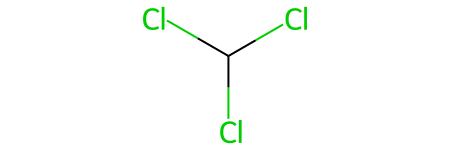

In [67]:
decoder_states[0].molecule

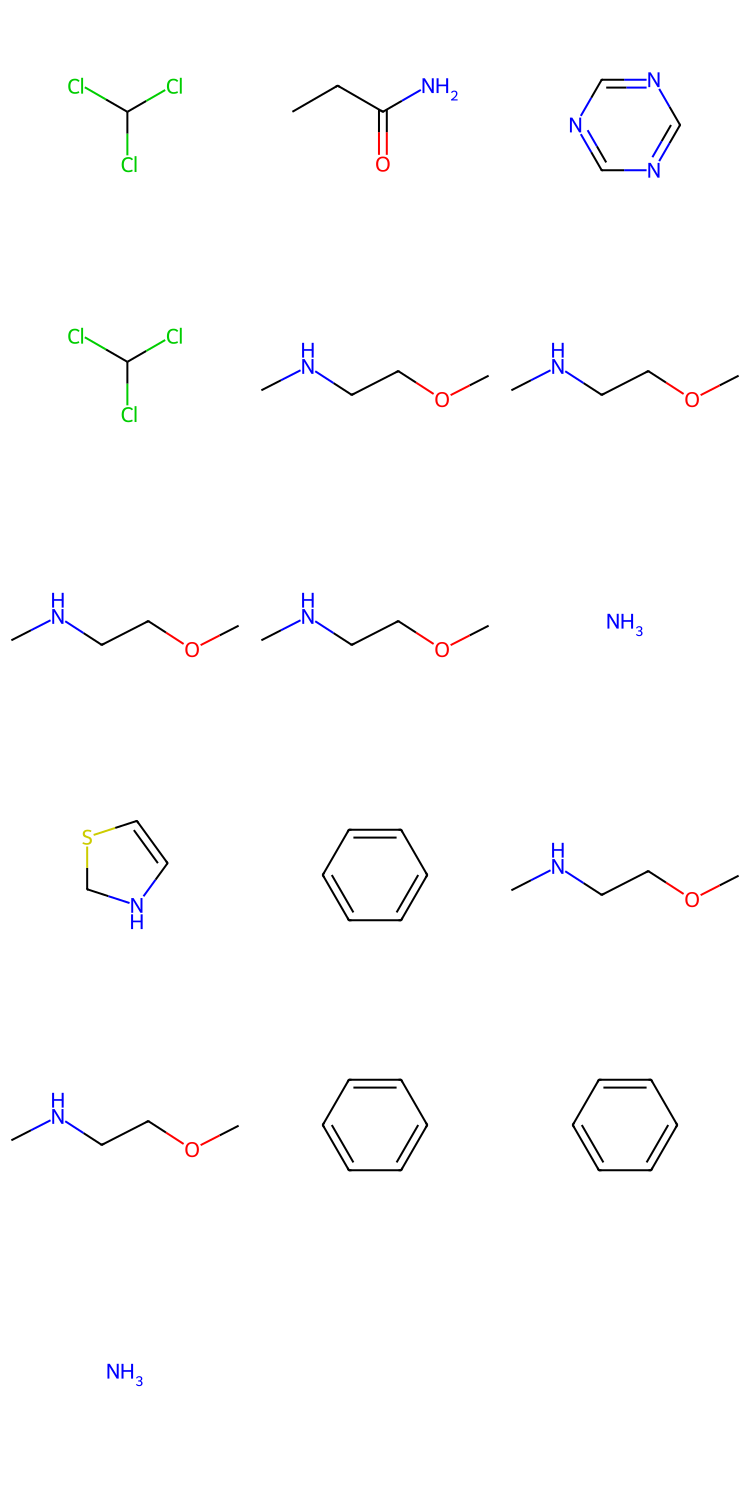

In [68]:


Draw.MolsToGridImage([decoder_states[i].molecule for i in range(len(decoder_states))], subImgSize=(250,250))


In [85]:
dataset._metadata['feature_extractors'][1].name

'Degree'

In [86]:
dataset._motif_vocabulary

MotifVocabulary(vocabulary={'C1=CC=CC=C1': 0, 'C1CCNCC1': 1, 'C1=CC=NC=C1': 2, 'NC=O': 3, 'C1CNCCN1': 4, 'C1CCNC1': 5, 'O=[N+][O-]': 6, 'C1CC1': 7, 'C1COCCN1': 8, 'O=CO': 9, 'N=CO': 10, 'C1=CNN=C1': 11, 'FC(F)F': 12, 'CC=O': 13, 'C1CCOCC1': 14, 'C1=CC=C2C=CC=CC2=C1': 15, 'COC=O': 16, 'CCO': 17, 'C=CC': 18, 'C1=CSC=N1': 19, 'C1=CSC=C1': 20, 'C1=CON=C1': 21, 'C1=CC=C2NC=CC2=C1': 22, 'OC(F)F': 23, 'O=CNO': 24, 'CNC=O': 25, 'CCNC(=O)OC': 26, 'CCCO': 27, 'CCC(N)=O': 28, 'CCC(=O)O': 29, 'CC(N)=O': 30, 'CC(C)C': 31, 'C1CCOC1': 32, 'C1CCCCC1': 33, 'C1=NC=C2CCCCC2=N1': 34, 'C1=COC=C1': 35, 'C1=CNC=C1': 36, 'C1=CN=CN=C1': 37, 'C1=CN=C2C=CC=CC2=C1': 38, 'C1=CN2N=CC=C2N=C1': 39, 'C1=CC=C2OC=CCC2=C1': 40, 'C1=CC=C2N=CC=CC2=C1': 41, 'C1=CC2=C(CCC2)S1': 42, 'O=S=O': 43, 'O=CNCCO': 44, 'O=CNCCCCCNC=O': 45, 'O=CNCCC(=O)O': 46, 'O=CCCO': 47, 'O=C(O)CS': 48, 'N[SH](=O)=O': 49, 'NNC=O': 50, 'NCCO': 51, 'NCCCC(N)=O': 52, 'NC(N)=O': 53, 'ClC(Cl)Cl': 54, 'CSCCC(N)C(=O)O': 55, 'COS(=O)(=O)CCC(N)=O': 56, 'CNCC

In [15]:
from torch_geometric.data import Batch

batch = Batch.from_data_list([dataset[0], dataset[1]], follow_batch = [
    'correct_edge_choices',
    'correct_edge_types',
    'valid_edge_choices',
    'valid_attachment_point_choices',
    'correct_attachment_point_choice',
    'correct_node_type_choices',
    'original_graph_x',
    'correct_first_node_type_choices'
])

In [16]:

atom_featurisers =dataset._metadata['feature_extractors']
motif_vocabulary=dataset._motif_vocabulary


for decoder_state in decoder_states:
    node_features, node_categorical_features = decoder_state.get_node_features(
        atom_featurisers, motif_vocabulary
    )
    mol_num_nodes = node_features.shape[0]

In [165]:
def _to_tensor_moler(decoder_state_features, ignore = []):
    for k, v in decoder_state_features.items():
        if k in ignore:
            continue
        decoder_state_features[k] = torch.tensor(decoder_state_features[k])
    return decoder_state_features



def batch_decoder_states(
    batch_size,
    atom_featurisers, #=dataset._metadata['feature_extractors'] ,
    motif_vocabulary,#=dataset._motif_vocabulary , 
    uses_categorical_features, #= True,
    decoder_states,#=decoder_states,
#     init_batch_callback=init_atom_choice_batch,
#     add_state_to_batch_callback=add_state_to_atom_choice_batch,
):
    current_batch = []
    for decoder_state in decoder_states:
        node_features, node_categorical_features = decoder_state.get_node_features(
            atom_featurisers, motif_vocabulary
        )
        mol_num_nodes = node_features.shape[0]
        
        decoder_state_features = {
            'latent_representation':decoder_state.molecule_representation, 
            'x': node_features,
            'node_categorical_features': node_categorical_features,
        }
        
        edge_indexes = []
        edge_types = []
        for edge_type_idx, adj_list in enumerate(decoder_state.adjacency_lists):
            if len(adj_list) > 0:
                edge_index = np.array(adj_list, dtype=np.int32).T
                edge_indexes += [edge_index]
                """ 
                edge types: 
                single bond => 0
                double bond => 1
                triple bond => 2
                self loop => 3
                """
                edge_types += [edge_type_idx] * len(adj_list)
#         print(edge_indexes)
        decoder_state_features["edge_index"] = (
            np.concatenate(edge_indexes, 1)
            if len(edge_indexes) > 0
            else np.array(edge_indexes)
        )
        decoder_state_features["edge_type"] = np.array(edge_types)
        
        decoder_state_features = _to_tensor_moler(decoder_state_features, ignore = ['latent_representation'])
#         print(decoder_state_features)
        current_batch += [(MolerData(**decoder_state_features), decoder_state)]
        if len(current_batch) == batch_size:
            tmp = current_batch
            current_batch = []
            yield (Batch.from_data_list([i[0] for i in tmp], follow_batch = [
                'correct_edge_choices',
                'correct_edge_types',
                'valid_edge_choices',
                'valid_attachment_point_choices',
                'correct_attachment_point_choice',
                'correct_node_type_choices',
                'original_graph_x',
                'correct_first_node_type_choices'
            ]), [i[1] for i in tmp])
    if len(current_batch) > 0:
        yield Batch.from_data_list(current_batch, follow_batch = [
            'correct_edge_choices',
            'correct_edge_types',
            'valid_edge_choices',
            'valid_attachment_point_choices',
            'correct_attachment_point_choice',
            'correct_node_type_choices',
            'original_graph_x',
            'correct_first_node_type_choices'
        ])
        


In [169]:
dataloader = batch_decoder_states(
    batch_size = 16,
    atom_featurisers =dataset._metadata['feature_extractors'] ,
    motif_vocabulary=dataset._motif_vocabulary , 
    uses_categorical_features = True,
    decoder_states=decoder_states,
)

In [170]:
for batch2 in dataloader:
    print(batch2)
#     break

(MolerDataBatch(x=[95, 32], edge_index=[2, 182], latent_representation=[16, 512], node_categorical_features=[95], edge_type=[182], batch=[95], ptr=[17]), [<molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692c8370>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692be520>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692bea90>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692befa0>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692bea00>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692beee0>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692be250>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692beb50>, <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState object at 0x7f4f692be460>, <molecul

In [171]:
batch2

(MolerDataBatch(x=[95, 32], edge_index=[2, 182], latent_representation=[16, 512], node_categorical_features=[95], edge_type=[182], batch=[95], ptr=[17]),
  <molecule_generation.utils.moler_decoding_utils.MoLeRDecoderState at 0x7f4f692bec40>])

In [ ]:
def _pick_attachment_points_for_batch(
    self,
    batch: Dict[str, Any],
    decoder_states: List[MoLeRDecoderState],
    num_samples: int,
    sampling_mode: DecoderSamplingMode,
):
    focus_atoms = np.array(
        [attachment_points[0] for attachment_points in batch["candidate_attachment_points"]]
    )
    candidate_attachment_points = np.concatenate(batch["candidate_attachment_points"], axis=0)

    graph_representations, node_representations = self.calculate_node_and_graph_representations(
        node_features=batch["node_features"],
        node_categorical_features=batch["node_categorical_features"],
        adjacency_lists=batch["adjacency_lists"],
        num_graphs_in_batch=batch["graphs_in_batch"],
        node_to_graph_map=batch["node_to_graph_map"],
        # Here we choose an arbitrary attachment point as a focus atom; this does not matter
        # since later all candidate attachment points are marked with the in-focus bit.
        graph_to_focus_node_map=focus_atoms,
        candidate_attachment_points=candidate_attachment_points,
        training=False,
    )

    attachment_point_selection_logits = self.pick_attachment_point(
        input_molecule_representations=batch["molecule_representations"],
        graph_representations=graph_representations,
        node_representations=node_representations,
        node_to_graph_map=batch["node_to_graph_map"],
        candidate_attachment_points=candidate_attachment_points,
        training=False,
    )  # Shape: [CA]

    attachment_point_to_graph_map = tf.gather(
        batch["node_to_graph_map"], candidate_attachment_points
    )

    # TODO(krmaziar): Consider tensorizing the code below. For that, we need some equivalent of
    # `unsorted_segment_argmax`.
    logits_by_graph: List[List[float]] = [[] for _ in range(len(decoder_states))]

    for logit, graph_id in zip(
        attachment_point_selection_logits, attachment_point_to_graph_map
    ):
        logits_by_graph[graph_id].append(logit)

    attachment_point_pick_results: List[List[Tuple[int, float]]] = []
    for old_decoder_state, attachment_point_logits in zip(decoder_states, logits_by_graph):
        attachment_point_logprobs = tf.nn.log_softmax(attachment_point_logits).numpy()
        picked_att_point_indices = sample_indices_from_logprobs(
            num_samples, sampling_mode, attachment_point_logprobs
        )

        this_state_results = []
        for attachment_point_pick_idx in picked_att_point_indices:
            attachment_point_pick = old_decoder_state.candidate_attachment_points[
                attachment_point_pick_idx
            ]
            attachment_point_logprob = attachment_point_logprobs[attachment_point_pick_idx]

            this_state_results.append((attachment_point_pick, attachment_point_logprob))
        attachment_point_pick_results.append(this_state_results)

    return attachment_point_pick_results, logits_by_graph

In [157]:
def _decoder_pick_attachment_points(
    decoder_states,
    sampling_mode = 'greedy',
    num_samples = 1
):
    if len(decoder_states) == 0:
        return [], np.zeros(shape=(0,))
    
    # We first need to create a minibatch of all of our partial graphs here:
    def init_attachment_point_choice_batch(batch):
        batch["candidate_attachment_points"] = []

    def add_state_to_attachment_point_choice_batch(
        batch, 
        decoder_state
    ):
        batch["candidate_attachment_points"].append(
            np.array(decoder_state.candidate_attachment_points) + batch["nodes_in_batch"]
        )

    attachment_point_pick_results = []
    logits_by_graph = []

    for batch, decoder_states_batch in batch_decoder_states(
        decoder_states=decoder_states,
        batch_size = 16,
        atom_featurisers =dataset._metadata['feature_extractors'] ,
        motif_vocabulary=dataset._motif_vocabulary , 
        uses_categorical_features = True,  
    ):
        pick_results_for_batch, logits_for_batch = _pick_attachment_points_for_batch(
            batch=batch,
            decoder_states=decoder_states_batch,
            num_samples=num_samples,
            sampling_mode=sampling_mode,
        )
        attachment_point_pick_results.extend(pick_results_for_batch)
        logits_by_graph.extend(logits_for_batch)
        
    return attachment_point_pick_results, logits_by_graph

In [158]:
_decoder_pick_attachment_points(decoder_states)

ValueError: too many values to unpack (expected 2)

In [ ]:

num_steps = 0
while num_steps < max_num_steps:
    # This will hold the results after this decoding step, grouped by input mol id:
    new_decoder_states: List[MoLeRDecoderState] = []
    num_steps += 1
    # Step 1: Split decoder states into subsets, dependent on what they need next:
    require_atom_states, require_bond_states, require_attachment_point_states = [], [], []
    for decoder_state in decoder_states:
        # No focus atom => needs a new atom
        if decoder_state.focus_atom is None:
            require_atom_states.append(decoder_state)
        # Focus atom has invalid index => decoding finished, just push forward unchanged:
        elif decoder_state.focus_atom < 0:
            new_decoder_states.append(decoder_state)
        else:
            require_bond_states.append(decoder_state)

    # Check if we are done:
    if (len(require_atom_states) + len(require_bond_states)) == 0:
        # print("I: Decoding finished")
        break

    # Step 2: For states that require a new atom, try to pick one:
    node_pick_results = self._decoder_pick_new_atom_types(
        decoder_states=require_atom_states,
        num_samples=beam_size,
        sampling_mode=sampling_mode,
    )

    for decoder_state, (node_type_picks, node_type_logprobs) in zip(
        require_atom_states, node_pick_results
    ):
        for node_type_pick, node_type_logprob in node_type_picks:
            # Set up generation trace storing variables, populating if needed.
            atom_choice_info = None
            if store_generation_traces:
                atom_choice_info = MoleculeGenerationAtomChoiceInfo(
                    node_idx=decoder_state.prior_focus_atom + 1,
                    true_type_idx=None,
                    type_idx_to_prob=np.exp(node_type_logprobs),
                )

            # If the decoder says we need no new atoms anymore, we are finished. Otherwise,
            # start adding more bonds:
            if node_type_pick is None:
                # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Finished decoding - p={node_type_logprob:5f}")
                new_decoder_states.append(
                    MoLeRDecoderState.new_for_finished_decoding(
                        old_state=decoder_state,
                        finish_logprob=node_type_logprob,
                        atom_choice_info=atom_choice_info,
                    )
                )
            else:
                new_decoder_state, added_motif = self._add_atom_or_motif(
                    decoder_state,
                    node_type_pick,
                    logprob=node_type_logprob,
                    choice_info=atom_choice_info,
                )

                if added_motif:
                    require_attachment_point_states.append(new_decoder_state)
                else:
                    require_bond_states.append(new_decoder_state)

    if self.uses_motifs:
        # Step 2': For states that require picking an attachment point, pick one:
        require_attachment_point_states = restrict_to_beam_size_per_mol(
            require_attachment_point_states, beam_size
        )
        (
            attachment_pick_results,
            attachment_pick_logits,
        ) = self._decoder_pick_attachment_points(
            decoder_states=require_attachment_point_states, sampling_mode=sampling_mode
        )

        for decoder_state, attachment_point_picks, attachment_point_logits in zip(
            require_attachment_point_states,
            attachment_pick_results,
            attachment_pick_logits,
        ):
            for (attachment_point_pick, attachment_point_logprob) in attachment_point_picks:
                attachment_point_choice_info = None
                if store_generation_traces:
                    attachment_point_choice_info = MoleculeGenerationAttachmentPointChoiceInfo(
                        partial_molecule_adjacency_lists=decoder_state.adjacency_lists,
                        motif_nodes=decoder_state.atoms_to_mark_as_visited,
                        candidate_attachment_points=decoder_state.candidate_attachment_points,
                        candidate_idx_to_prob=tf.nn.softmax(attachment_point_logits),
                        correct_attachment_point_idx=None,
                    )

                # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Picked attachment point {attachment_point_pick} - p={attachment_point_logprob:5f}")
                require_bond_states.append(
                    MoLeRDecoderState.new_with_focus_on_attachment_point(
                        decoder_state,
                        attachment_point_pick,
                        focus_atom_logprob=attachment_point_logprob,
                        attachment_point_choice_info=attachment_point_choice_info,
                    )
                )
    else:
        assert not require_attachment_point_states

    # Step 3: Pick fresh bonds and populate the next round of decoding steps:
    require_bond_states = restrict_to_beam_size_per_mol(require_bond_states, beam_size)
    bond_pick_results = self._decoder_pick_new_bond_types(
        decoder_states=require_bond_states,
        store_generation_traces=store_generation_traces,
        sampling_mode=sampling_mode,
    )
    for (decoder_state, (bond_picks, edge_choice_info)) in zip(
        require_bond_states, bond_pick_results
    ):
        if len(bond_picks) == 0:
            # There were no valid options for this bonds, so we treat this as if
            # predicting no more bonds with probability 1.0:
            # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: No more allowed bonds to node {decoder_state.focus_atom}")
            new_decoder_states.append(
                MoLeRDecoderState.new_with_focus_marked_as_visited(
                    decoder_state,
                    focus_node_finished_logprob=0,
                    edge_choice_info=edge_choice_info,
                )
            )
            continue

        for (bond_pick, bond_pick_logprob) in bond_picks:
            # If the decoder says we need no more bonds for the current focus node,
            # we mark this and put the decoder state back for the next expansion round:
            if bond_pick is None:
                # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Finished connecting bonds to node {decoder_state.focus_atom} - p={bond_pick_logprob:5f}")
                new_decoder_states.append(
                    MoLeRDecoderState.new_with_focus_marked_as_visited(
                        decoder_state,
                        focus_node_finished_logprob=bond_pick_logprob,
                        edge_choice_info=edge_choice_info,
                    )
                )
            else:
                (picked_bond_target, picked_bond_type) = bond_pick

                # print(I {decoder_state.molecule_id} {decoder_state.logprob:12f}: Adding {decoder_state.focus_atom}-{picked_bond_type}->{picked_bond_target} - p={bond_pick_logprob:5f}")
                new_decoder_states.append(
                    MoLeRDecoderState.new_with_added_bond(
                        old_state=decoder_state,
                        target_atom_idx=int(
                            picked_bond_target
                        ),  # Go from np.int32 to pyInt
                        bond_type_idx=picked_bond_type,
                        bond_logprob=bond_pick_logprob,
                        edge_choice_info=edge_choice_info,
                    )
                )

    # Everything is done, restrict to the beam width, and go back to the loop start:
    decoder_states = restrict_to_beam_size_per_mol(new_decoder_states, beam_size)